# Lab 4
Welcome to the fourth lab. In this lab, we will work with another regularization.

## Imports

In [16]:
from typing import Optional, List, Tuple

import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import Tensor

set_matplotlib_formats('png', 'pdf')



# OLS → Ridge → Lasso

You'll work through three linear models on a small **deterministic** dataset:

1. **OLS** (normal equations)  
2. **Ridge** (closed-form; L2 penalty)  
3. **Lasso** (coordinate descent; L1 penalty)

We'll end with a side-by-side comparison.


## Step 0 — Load the dataset

In [17]:
def get_data():
    """
    Deterministic dataset (n=8, p=4).
    y is generated from: y = -0.5 + 2*x0 - 1.5*x2 + noise (small, fixed).
    """
    X = np.array([
        [1,0,2,0],
        [0,1,0,1],
        [2,1,0,0],
        [0,0,1,2],
        [1,2,0,1],
        [2,0,1,0],
        [1,1,1,1],
        [0,2,2,0],
    ], dtype=float)
    y = np.array([-0.5 + 2.0*(x0) + -1.5*(x2) + e for (x0, x1, x2, x3), e in zip(
        X,
        [0.10, -0.20, 0.05, 0.00, -0.05, 0.20, -0.10, 0.15]
    )], dtype=float)
    return X, y

X, y = get_data()
print("X shape:", X.shape, " y shape:", y.shape)
print("First 3 rows of X:\n", X[:3])
print("First 3 y:", y[:3])


X shape: (8, 4)  y shape: (8,)
First 3 rows of X:
 [[1. 0. 2. 0.]
 [0. 1. 0. 1.]
 [2. 1. 0. 0.]]
First 3 y: [-1.4  -0.7   3.55]



## Task 1 — OLS (Normal Equations)
Implement OLS via $\tilde X^\top \tilde X \theta = \tilde X^\top y$ using `np.linalg.solve`.


In [18]:
def fit_ols_normal_eq(X, y):
    x_tilde = np.column_stack([np.ones(X.shape[0]), X])
    return np.linalg.solve(x_tilde.T @ x_tilde, x_tilde.T @ y)


## Task 1b — OLS (Gradient Descent) with Epoch Logging
Implement GD updates and record '($\beta$, intercept)` at each epoch.


In [19]:
def fit_ols_gd_with_history(X, y, epochs=120, lr=0.05):
    n, p = X.shape
    beta = np.zeros(p)
    b = 0.0
    history = []

    for _ in range(epochs):
        y_hat = X @ beta + b
        r = y_hat - y
        grad_b = (2.0/n) * r.sum()
        grad_beta = (2.0/n) * (X.T @ r)

        b -= lr * grad_b
        beta -= lr * grad_beta

        history.append((beta.copy(), b))

    return beta, b, history


## What is Ridge?

**Ridge regression** adds an \(L_2\) penalty to the OLS loss:

$
\min_{\beta,\,b}\; \frac{1}{2n}\sum_{i=1}^n (y_i - b - x_i^\top \beta)^2 \;+\; \frac{\lambda}{2}\|\beta\|_2^2
$

- Closed-form (intercept unpenalized): $ \theta = (\tilde X^\top \tilde X + \lambda D)^{-1}\tilde X^\top y , D=\mathrm{diag}(0,1,\ldots,1)$.



## Task 2 — Ridge (Closed-Form, intercept unpenalized)
Implement closed-form Ridge with $D=diag(0,1,...,1)$.


In [20]:
def fit_ridge_closed_form(X, y, lam=0.5):
    n, p = X.shape
    X_tilde = np.column_stack([np.ones(n), X])
    D = np.diag([0] + [1]*p)
    A = X_tilde.T @ X_tilde + lam * D
    return np.linalg.solve(A, X_tilde.T @ y)


## Task 2b — Ridge (Gradient Descent) with Epoch Logging
Implement GD with gradient $\frac{1}{n} \tilde X^\top \tilde X \theta - y + \lambda * D \theta$.


In [21]:
def fit_ridge_gd_with_history(X, y, lam=0.5, epochs=120, lr=0.05):
    n, p = X.shape
    X_tilde = np.column_stack([np.ones(n), X])
    D = np.diag([0] + [1]*p)
    theta = np.zeros(p + 1)
    history = []

    for _ in range(epochs):
        r = X_tilde @ theta - y
        grad = (1.0/n) * (X_tilde.T @ r) + lam * (D @ theta)
        theta -= lr * grad
        history.append((theta[1:].copy(), float(theta[0])))

    return theta, history



## What is Lasso?

**Lasso** (Least Absolute Shrinkage and Selection Operator) solves

$
\min_{\beta,\,b}\; \frac{1}{2n}\sum_{i=1}^n (y_i - b - x_i^\top \beta)^2 \;+\; \alpha \|\beta\|_1
$

- The $L_1$ penalty encourages **sparse** coefficients — some become exactly zero.



## Task 3 — Lasso (Coordinate Descent) with Epoch Logging
Standardize features; after each full sweep, append rescaled `(beta, intercept)` to history.


In [22]:
def soft_threshold(z, g):
    # S(z, g) = sign(z) * max(|z| - g, 0)
    if z > g:
        return z - g
    elif z < -g:
        return z + g
    else:
        return 0.0

def fit_lasso_cd_with_history(X, y, alpha=0.2, epochs=40):
    n, p = X.shape

    X_mean = X.mean(axis=0)
    X_std  = X.std(axis=0, ddof=0)
    X_std[X_std == 0] = 1.0
    Xs = (X - X_mean) / X_std

    y_mean = y.mean()
    yc = y - y_mean

    aj = (Xs**2).sum(axis=0) / n

    beta_s = np.zeros(p)
    history = []

    for _ in range(epochs):
        for j in range(p):
            r = yc - (Xs @ beta_s) + Xs[:, j] * beta_s[j]
            cj = (Xs[:, j] @ r) / n
            beta_s[j] = soft_threshold(cj, alpha) / aj[j]

        beta_orig = beta_s / X_std
        intercept_orig = y_mean - (X_mean @ beta_orig)

        history.append((beta_orig.copy(), float(intercept_orig)))

    return beta_orig, intercept_orig, history



## Exercise 4 — Plot Coefficient Trajectories over Epochs (2P)
Make three plots (one per model) showing beta_j vs epoch.


In [23]:

def plot_hist(hist, title):
    betas = np.array([b for (b, _) in hist])
    epochs = np.arange(1, len(hist) + 1)

    plt.figure()
    for j in range(betas.shape[1]):
        plt.plot(epochs, betas[:, j], label=f"β{j+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Coefficient value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

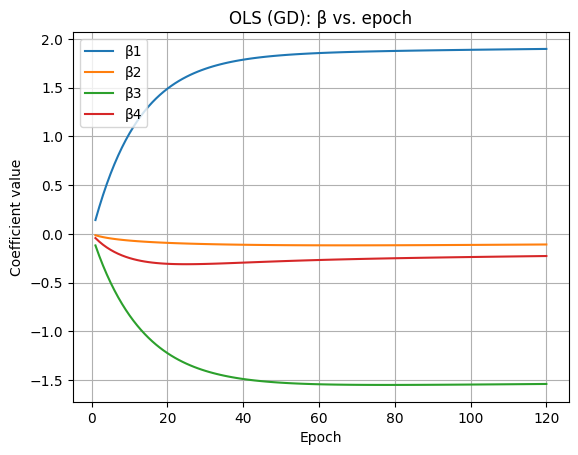

In [24]:
beta_ols, b_ols, hist_ols = fit_ols_gd_with_history(X, y, epochs=120, lr=0.05)
plot_hist(hist_ols, "OLS (GD): β vs. epoch")

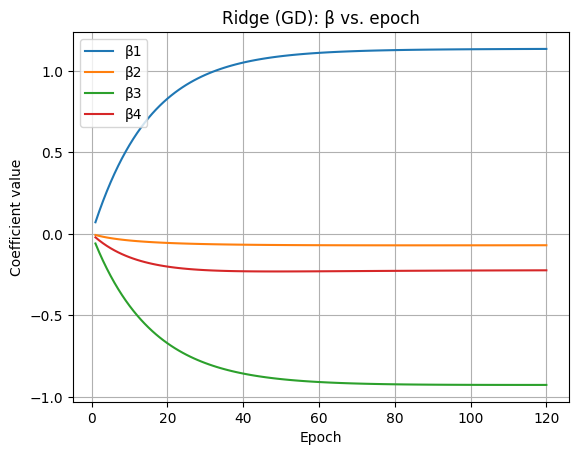

In [25]:
theta_ridge, hist_ridge = fit_ridge_gd_with_history(X, y, lam=0.5, epochs=120, lr=0.05)
plot_hist(hist_ridge, "Ridge (GD): β vs. epoch")

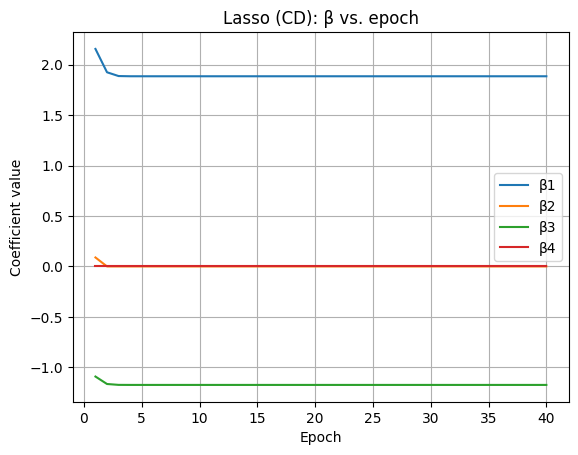

In [26]:
beta_lasso, b_lasso, hist_lasso = fit_lasso_cd_with_history(X, y, alpha=0.2, epochs=40)
plot_hist(hist_lasso, "Lasso (CD): β vs. epoch")